In [0]:
 #Feature Engineering


  # Clean and pre-process the text data.
  # Define features for comparing the similarity of an answer text and a source text, and extract similarity features.
  # Select "good" features, by analyzing the correlations between different features.
  # Create train/test .csv/.txt files that hold the relevant features and class labels for train/test data points.


In [0]:
# import libraries
import pandas as pd
import numpy as np
import os
import operator 
import re
import matplotlib.pyplot as plt

In [0]:
#more libraries

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from collections import Counter
import string
from scipy.sparse import hstack

Using TensorFlow backend.


In [0]:
pip install liwc

In [0]:

import string
import sys



In [0]:
# Have to mount my drive otherwise I cannot import data from drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#csv_file = '/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/Textfiles/UpdatedData.csv'

csv_file = '/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/Textfiles/UpdatedDataCopy.csv'

plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head(10)

,Label,File,Task,Category,Text
0,French,article-0-0,a,Fren,"Résumé \nDans ce papier, nous proposons une mé..."
1,English,article-0-0,a,ManuT,"Abstract In this paper, we propose a method fo..."
2,TEng,article-0-0,a,MachT,"Summary\nIn this paper, we propose a method fo..."
3,French,article-0-14,a,Fren,Intuition\nNous cherchons à évaluer si une req...
4,English,article-0-14,a,ManuT,Intuition\nThe measure should assess to which ...
5,TEng,article-0-14,a,MachT,Intuition\nWe seek to assess whether a request...
6,French,article-0-16,a,Fren,"Ainsi, nous proposons d’étendre rappel et préc..."
7,English,article-0-16,a,ManuT,We propose to extend recall and precision by t...
8,TEng,article-0-16,a,MachT,"Thus, we propose to extend recall and precisio..."
9,French,article-0-2,a,Fren,"Dans cet article, nous développons les travaux..."


#Convert Categorical Data to discrete 




*   0 = French
*  1= Manual Translation


*   2 = Machine Translation
*   -1 = OG English (Might not be used or only to compare features of translations )








 Class labels



*   1 = Manual Translation
*   2 = Machine Translation


*    -1= Originally English
*   0 = Originally French








Comparisons 



*   Manual Translation v. Machine Translation
*   Originally English v. Manual Translation and (Machine Translation)
*   Can we compare Manual and Machine translations to see if orignal language was English or French? (Can use semantiment analysis and cross language word embeddings)



In [0]:
# Read in a csv file and return a transformed dataframe
def numerical_dataframe(csv_file='/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/Textfiles/UpdatedData.csv'):
    '''Reads in a csv file which is assumed to have `File`, `Category` and `Task` columns.
       This function does two things: 
       1) converts `Category` column values to numerical values 
       2) Adds a new, numerical `Class` label column.
       The `Class` column will label plagiarized answers as 1 and non-plagiarized as 0.
       Source texts have a special label, -1.
       :param csv_file: The directory for the file_information.csv file
       :return: A dataframe with numerical categories and a new `Class` label column'''
    
    plagiarism_df = pd.read_csv(csv_file)
    
    labels = {
        "Fren":0, # "Fren" :0
        "ManuT":1, # "ManuT":1,
        "MachT":2, #"MachT":2
        "Eng":-1  #Eng":-1
    }
    plagiarism_df['Category'] = plagiarism_df.Category.map(labels)
    plagiarism_df['Class'] = plagiarism_df.Category.apply(lambda x: 0 if x == 0 else (-1 if x==-1 else 1))  #(lambda x: 0 if x == 0 else (-1 if x==-1 else 1))
    return plagiarism_df

In [0]:
#informal testing, print out the results of a called function
# create new `transformed_df`
transformed_df = numerical_dataframe(csv_file ='/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/Textfiles/UpdatedDataCopy.csv')

# check work
transformed_df.head(10)

,Label,File,Task,Category,Text,Class
0,French,article-0-0,a,0,"Résumé \nDans ce papier, nous proposons une mé...",0
1,English,article-0-0,a,1,"Abstract In this paper, we propose a method fo...",1
2,TEng,article-0-0,a,2,"Summary\nIn this paper, we propose a method fo...",1
3,French,article-0-14,a,0,Intuition\nNous cherchons à évaluer si une req...,0
4,English,article-0-14,a,1,Intuition\nThe measure should assess to which ...,1
5,TEng,article-0-14,a,2,Intuition\nWe seek to assess whether a request...,1
6,French,article-0-16,a,0,"Ainsi, nous proposons d’étendre rappel et préc...",0
7,English,article-0-16,a,1,We propose to extend recall and precision by t...,1
8,TEng,article-0-16,a,2,"Thus, we propose to extend recall and precisio...",1
9,French,article-0-2,a,0,"Dans cet article, nous développons les travaux...",0


# Helper Functions

I borrowed some of these helper functions from elsewhere

In [0]:
# helper function for pre-processing text given a file
def process_file(text):
    # put text in all lower case letters 
    all_text = text.lower()

    # remove all non-alphanumeric chars
    all_text = re.sub(r"[^a-zA-Z0-9]", " ", all_text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    all_text = re.sub(r"\t", " ", all_text)
    all_text = re.sub(r"\n", " ", all_text)
    all_text = re.sub("  ", " ", all_text)
    all_text = re.sub("   ", " ", all_text)
    
    return all_text

In [0]:
def create_text_column(df, file_directory='data/'):
    '''Reads in the files, listed in a df and returns that df with an additional column, `Text`. 
       :param df: A dataframe of file information including a column for `File`
       :param file_directory: the main directory where files are stored
       :return: A dataframe with processed text '''
   
    # create copy to modify
    text_df = df.copy()
    
    # store processed text
    text = []
    
    # for each file (row) in the df, read in the file 
    for row_i in df.index:
        filename = df.iloc[row_i]['Text']
        #print(filename)
        #file_path = file_directory + filename
        #with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:

            # standardize text using helper function
        file_text = process_file(filename)
            # append processed text to list
        text.append(file_text)
    
    # add column to the copied dataframe
    text_df['Text'] = text
    
    return text_df

# Preprocessing

In [0]:
text_df = create_text_column(transformed_df)
text_df.head()

,Label,File,Task,Category,Text,Class
0,French,article-0-0,a,0,r sum dans ce papier nous proposons une m tho...,0
1,English,article-0-0,a,1,abstract in this paper we propose a method for...,1
2,TEng,article-0-0,a,2,summary in this paper we propose a method for ...,1
3,French,article-0-14,a,0,intuition nous cherchons valuer si une requ t...,0
4,English,article-0-14,a,1,intuition the measure should assess to which e...,1


In [0]:
complete_df = text_df

# Split into Training and Test Set

In [0]:
complete_df.axes

[RangeIndex(start=0, stop=303, step=1),
 Index(['Label', 'File', 'Task', 'Category', 'Text', 'Class'], dtype='object')]

In [0]:
complete_df.shape

(303, 6)

In [0]:
complete_df.dtypes

Label       object
File        object
Task        object
Category     int64
Text        object
Class        int64
dtype: object

In [0]:
df= complete_df
Manut_df= df[df["Label"]== "English"] 
Macht_df = df[df["Label"]== "TEng"]
OG = df[df["Label"]== "OG_ENG_ESSAY"]
complete_df= pd.concat([Manut_df,Macht_df, OG])

# Get specific Dataframes for task

My CompleteDF has all of my data including OG English and French which I do not need right now. I just want to have Machine Translations and Manual Translations in a dataframe

#Feature Engineering

List of plagirism features

1.   containment (https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf)
2.   lcs(Longest Common Subsequence)

3.   word embeddings(Elmo/Word2vec)
4.   Something for cross language similarity?(https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126196)



5.   Vader( would hypothesis that a machine translation might lose some of the original sentiment that a manual translation might strive to capture)
6.   Maybe look into a Semantic feature for cross language and cross translation analysis 

7. Punctuation and POS types

8. Mispelled words







# Vader implementation 

In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
pip install twython

In [0]:
#Sentiment Analysis for similarity matching 


import nltk
nltk.download('vader_lexicon')

#Sentiment Analyzer VADER
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

nltk_results = [nltk_sentiment(row) for row in complete_df["Text"]]
results_df = pandas.DataFrame(nltk_results)
complete_df = complete_df.join(results_df)


SyntaxError: ignored

In [0]:
features_df = complete_df

In [0]:
# creating lists to keep pos, neu, neg, and compound scores --- later to be used to create a dataframe
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

# extracting vader scores for each entry in the data
# (we're not using context yet.)
# note that the compound score is rescaled to the [0,1] range
# some classiifers don't take negative values (e.g., MultinomialNB)

for row in complete_df["Text"]:
    score = nltk_sentiment(row)
  
    neg = float(score['neg'])
    vs_neg.append(neg)
    neu =float(score['neu'])
    vs_neu.append(neu)
    pos =float(score['pos'])
    vs_pos.append(pos)
    compound = float((score['compound']+1)/2) # rescaling to the [0,1] range
    vs_compound.append(compound)
   # vader_df = pd.DataFrame(complete_df["text"])      


##Create feature vector 
features_df["vader_pos"] = vs_pos
features_df["vader_neg"] = vs_neg
features_df["vader_neu"] = vs_neu
features_df["vader_compound"] = vs_compound

In [0]:
features_df.dtypes

# Cosine Similarity 

# Other features

In [0]:
#### Be creative with features --- these are just examples ##############       
    
#Word Count of the documents – total number of words in the documents
#Character Count of the documents – total number of characters in the documents
#Average Word Density of the documents – average length of the words used in the documents
#Puncutation Count in the Complete Essay – total number of punctuation marks in the documents
#Upper Case Count in the Complete Essay – total number of upper count words in the documents
#Title Word Count in the Complete Essay – total number of proper case (title) words in the documents
#Frequency distribution of Part of Speech Tags:
#Noun Count
#Verb Count
#Adjective Count
#Adverb Count
#Pronoun Count
        
        
# Here you can play with features -- add new ones; edit, remove.
complete_df['char_count'] = complete_df['Text'].apply(len)
complete_df['word_count'] = complete_df['Text'].apply(lambda x: len(x.split()))
complete_df['word_density'] = complete_df['char_count'] / (complete_df['word_count']+1)
#complete_df['punctuation_count'] = complete_df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
#complete_df['title_word_count'] = complete_df['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
#complete_df['upper_case_word_count'] = complete_df['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}
from textblob import TextBlob
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

complete_df['noun_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'noun'))
complete_df['verb_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'verb'))
complete_df['adj_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'adj'))
complete_df['adv_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'adv'))
complete_df['pron_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'pron'))


# Create feature vector 

In [0]:
##TODO convert features to floats


features_df['char_count'] = complete_df['Text'].apply(len).astype(float)
features_df['word_count'] = complete_df['Text'].apply(lambda x: len(x.split())).astype(float)
features_df['word_density'] = complete_df['char_count']/ (complete_df['word_count']+1).astype(float)
##features_df['punctuation_count'] = complete_df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))).astype(float)
###features_df['title_word_count'] = complete_df['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])).astype(float) #unnecsaarry
###features_df['upper_case_word_count'] = complete_df['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])).astype(float) #also unnecssary  

In [0]:

##Create feature vector 

features_df['noun_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'noun')).astype(float)
features_df['verb_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'verb')).astype(float)
features_df['adj_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'adj')).astype(float)
features_df['adv_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'adv')).astype(float)
features_df['pron_count'] = complete_df['Text'].apply(lambda x: check_pos_tag(x, 'pron')).astype(float)


In [0]:
features_df.head(10)

In [0]:
features_df.tail()

In [0]:
features_df.dtypes

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Create correlation matrix for just Features to determine different models to test
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,Category,Class,char_count,word_count,word_density,noun_count,verb_count,adj_count,adv_count,pron_count
Category,1.00,0.96,0.54,0.48,0.49,0.57,0.47,0.49,0.11,0.11
Class,0.96,1.00,0.57,0.50,0.51,0.60,0.50,0.51,0.10,0.12
char_count,0.54,0.57,1.00,0.99,0.34,0.94,0.91,0.82,0.41,0.33
word_count,0.48,0.50,0.99,1.00,0.19,0.93,0.91,0.80,0.46,0.36
word_density,0.49,0.51,0.34,0.19,1.00,0.31,0.22,0.36,0.11,0.04
noun_count,0.57,0.60,0.94,0.93,0.31,1.00,0.81,0.73,0.28,0.20
verb_count,0.47,0.50,0.91,0.91,0.22,0.81,1.00,0.69,0.38,0.34
adj_count,0.49,0.51,0.82,0.80,0.36,0.73,0.69,1.00,0.34,0.27
adv_count,0.11,0.10,0.41,0.46,0.11,0.28,0.38,0.34,1.00,0.25
pron_count,0.11,0.12,0.33,0.36,0.04,0.20,0.34,0.27,0.25,1.00


# Get rid of unnecessary OBJ types

In [0]:
features_df = features_df.drop(['Label', 'File','Task' ], axis=1)

In [0]:
features_df.fillna(0)  ## some of the Vader values have NAn

# Append Features

In [0]:
training_x, validating_x, train_y, valid_y =  model_selection.train_test_split(features_df,features_df['Category'], train_size=0.6,test_size=0.4)

train_x = training_x
valid_x = validating_x


"""label encode the target variable for ML --> numeric 
Makes labels binary
"""
from keras.utils import to_categorical
train_y_hot = to_categorical(train_y)
valid_y_hot = to_categorical(valid_y)


encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)  #I think this got rid of one of my labels
valid_y = encoder.fit_transform(valid_y)

In [0]:
train_y

In [0]:
train_x 

In [0]:
"""### Matrix/Count Vectorizer
count_vect: every row represents a document from the corpus;
every column is a term from the corpus;
every cell represents the freq count of a particular term in particular document
create a count vectorizer object for the training data

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.
"""

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}') # word that appears 1 or more times
count_vect.fit(train_x['Text'])
count_vect.fit(valid_x['Text'])
# to show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
count_vect.vocabulary_

# transform the training and validation data using count vectorizer object: doc x term
xtrain_count =  count_vect.transform(train_x['Text']) 
xvalid_count =  count_vect.transform(valid_x['Text'])

"""## Extracting Features

### word level tf-idf
"""

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000) # considers the top 5000 most frequent features
tfidf_vect.fit(train_x['Text'])
tfidf_vect.fit(valid_x['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x['Text'])
xvalid_tfidf =  tfidf_vect.transform(valid_x['Text'])

"""### ngram level tf-idf"""

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train_x['Text'])
tfidf_vect_ngram.fit(valid_x['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x['Text'])
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x['Text'])

"""### characters level tf-idf"""

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train_x['Text'])
tfidf_vect_ngram_chars.fit(valid_x['Text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x['Text']) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x['Text'])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


#Word Embeddings

[1] Daniel C. Ferreira, AndrÃ© F. T. Martins, and Mariana S. C. Almeida.
"Jointly Learning to Embed and Predict with Multiple Languages."
Annual Meeting of the Association for Computational Linguistics (ACL'16), Berlin, Germany, August 2016.
To appear.



In [0]:
training_xx = train_x.drop(['Text' ], axis=1)
valid_xx = valid_x.drop(['Text' ], axis=1)

#All Features together

In [0]:
embeddings_index = {}
for i, line in enumerate(open('/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(complete_df['Text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x['Text']), maxlen=200)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x['Text']), maxlen=200)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
features_train_all= hstack([xtrain_tfidf,xtrain_tfidf_ngram,xtrain_tfidf_ngram_chars, training_xx])
features_valid_all =hstack([xvalid_tfidf, xvalid_tfidf_ngram, xvalid_tfidf_ngram_chars, valid_xx])

In [0]:
features_train_all

<141x10670 sparse matrix of type '<class 'numpy.float64'>'
	with 88194 stored elements in COOrdinate format>

#Create CSV files for model

In [0]:
def make_csv(x,filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
  
    #pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).to_csv(os.path.join(data_dir, filename), header=False, index=False)
    pd.DataFrame(x).to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [0]:
""""data_dir = '/content/drive/My Drive/Colab Notebooks/CrossLanguagePlagirism/test_training_files'



make_csv(training_xx,filename='training_xx .csv', data_dir=data_dir)
make_csv(train_y, filename='train_y.csv', data_dir=data_dir)
make_csv(valid_xx ,filename='valid_xx .csv', data_dir=data_dir)
make_csv(valid_y,filename='valid_y.csv', data_dir=data_dir)


make_csv(xtrain_count,filename='xtrain_count.csv', data_dir=data_dir)
make_csv(xtrain_count,filename='xvalid_count.csv', data_dir=data_dir)

make_csv(xtrain_tfidf,filename='xtrain_tfidf.csv', data_dir=data_dir)
make_csv(xvalid_tfidf,filename='xvalid_tfidf.csv', data_dir=data_dir)

make_csv(xtrain_tfidf_ngram,filename='xtrain_tfidf_ngram.csv', data_dir=data_dir)
make_csv(xtrain_tfidf_ngram,filename='xvalid_tfidf_ngram.csv', data_dir=data_dir)

make_csv(xtrain_tfidf_ngram_chars,filename='xtrain_tfidf_ngram_chars.csv', data_dir=data_dir)
make_csv(xvalid_tfidf_ngram_chars,filename='xvalid_tfidf_ngram_chars.csv', data_dir=data_dir)

make_csv(features_train_all,filename='features_train_all.csv', data_dir=data_dir)
make_csv(features_valid_all,filename='features_valid_all.csv', data_dir=data_dir) """

#Classification

Move on to classifier notebook

Multiclass Classification: A classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multi-class classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

In [0]:
#    
#    
# Model Building
   # fit the training dataset on the classifier 
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
   # fit the training dataset on the classifier 
  classifier.fit(feature_vector_train, label)

  # predict the labels on validation dataset
  predictions = classifier.predict(feature_vector_valid)

  if is_neural_net:
      predictions = predictions.argmax(axis=-1)

  return metrics.accuracy_score(predictions, valid_y)

## If you'd like to output precision, recall, F-score, etc.  
##  See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [0]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

accuracy = train_model(svm.SVC(), features_train_all, train_y, features_valid_all)
print ("SVM, All features Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.5106382978723404
SVM, All features Vectors:  0.425531914893617


In [0]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)  #Should modify for multiclass classification
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ( "NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, TF IDF Vectors: ", accuracy)
# Naive Bayes on All features
accuracy= train_model(naive_bayes.MultinomialNB(), features_train_all, train_y, features_valid_all)
print ("NB, All features: ",accuracy)

NB, Count Vectors:  0.5957446808510638
NB, WordLevel TF-IDF:  0.5319148936170213
NB, N-Gram Vectors:  0.425531914893617
NB, TF IDF Vectors:  0.4148936170212766


ValueError: ignored

In [0]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((200, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer: not sure it's needed here
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RCNN, Word Embeddings",  accuracy)

Epoch 1/1
141/141 [==============================] - 1s 5ms/step - loss: 0.5688
RCNN, Word Embeddings 0.40425531914893614


In [0]:
features_train_all.shape[1]

10670

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

EMBEDDING_DIM = 100

num_words = len(word_index)+ 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

max_length = 200
print('Build model...')

model = Sequential()

model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer= Constant(embedding_matrix),
                    input_length = max_length,
                    trainable= False))

model.add(GRU(units=32, dropout= 0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          364500    
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 377,367
Trainable params: 12,867
Non-trainable params: 364,500
_________________________________________________________________
None


In [0]:
print(train_y_hot)

In [0]:
print(train_y_hot.shape)

In [0]:
"""'from keras.utils import to_categorical
train_y = to_categorical(train_y)
valid_y = to_categorical(valid_y)
print(train_y.shape)

In [0]:
num_epochs = 700
batch_size = 110
history = model.fit(train_seq_x, train_y_hot, batch_size=batch_size, epochs=num_epochs, verbose =2, validation_split=0.2)
#history = model.fit(train_seq_x, train_y, batch_size=batch_size, epochs=num_epochs, verbose =2, validation_split=0.2)



Train on 112 samples, validate on 29 samples
Epoch 1/700
 - 1s - loss: 1.0985 - accuracy: 0.0179 - val_loss: 1.0921 - val_accuracy: 0.6897
Epoch 2/700
 - 0s - loss: 1.0911 - accuracy: 0.6696 - val_loss: 1.0844 - val_accuracy: 0.6897
Epoch 3/700
 - 0s - loss: 1.0820 - accuracy: 0.6696 - val_loss: 1.0760 - val_accuracy: 0.6897
Epoch 4/700
 - 0s - loss: 1.0724 - accuracy: 0.6696 - val_loss: 1.0670 - val_accuracy: 0.6897
Epoch 5/700
 - 0s - loss: 1.0615 - accuracy: 0.6696 - val_loss: 1.0576 - val_accuracy: 0.6897
Epoch 6/700
 - 0s - loss: 1.0500 - accuracy: 0.6696 - val_loss: 1.0475 - val_accuracy: 0.6897
Epoch 7/700
 - 0s - loss: 1.0372 - accuracy: 0.6696 - val_loss: 1.0366 - val_accuracy: 0.6897
Epoch 8/700
 - 0s - loss: 1.0221 - accuracy: 0.6696 - val_loss: 1.0250 - val_accuracy: 0.6897
Epoch 9/700
 - 0s - loss: 1.0049 - accuracy: 0.6696 - val_loss: 1.0128 - val_accuracy: 0.6897
Epoch 10/700
 - 0s - loss: 0.9872 - accuracy: 0.6696 - val_loss: 1.0000 - val_accuracy: 0.6897
Epoch 11/700
 

In [0]:
score, acc = model.evaluate(valid_seq_x, valid_y_hot, batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.7659574747085571


# Confusion Matrix



In [0]:
import tensorflow as tf


y_pred=model.predict_classes(valid_seq_x)
con_mat = tf.math.confusion_matrix(labels=valid_y, predictions=y_pred).numpy()

In [0]:
classes = [0,1,2]

In [0]:

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


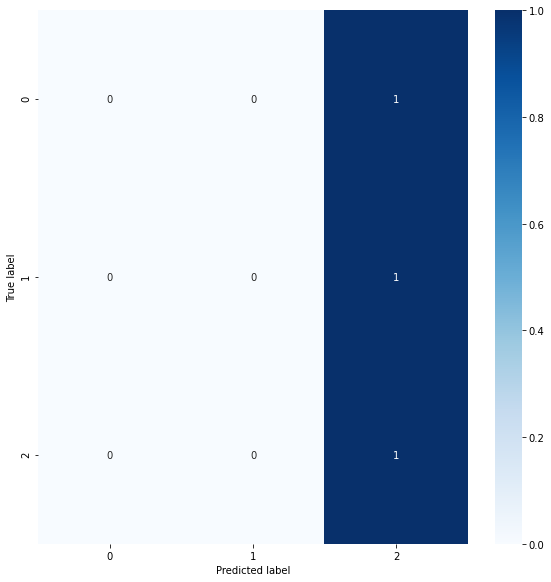

In [0]:
import seaborn as sns


figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()